#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import root
from scipy.integrate import solve_ivp
from scipy import interpolate
import scipy

In [2]:
import sys
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 50

In [6]:
mi = [mp for i in range(node_N)]

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn = 27_162_500 #123000000 # mass of the vessel, [kg]

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
Irho_=np.diag(diag_Irho)

In [11]:
Irho_

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [16]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [17]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [18]:
E = 210e9

In [19]:
E*Ar/1e10

1.6991625880187402

In [20]:
diag_DT = 1.5*np.array([1, 1, 1])

In [21]:
DT=np.diag(diag_DT) # (35) in [2]

In [22]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [23]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [24]:
CT=np.diag(diag_CT)

In [25]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [26]:
# angles should be in radians, otherwise np.radians them
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]

    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])


    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [27]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [28]:
rng = np.random.default_rng()

In [29]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [30]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [31]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[ 0.89322742, -0.24928176,  0.37417026],
       [-0.40949282, -0.10745118,  0.9059635 ],
       [-0.18563514, -0.96245148, -0.19805743]])

In [32]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.002266


In [33]:
Ret.shape

(50, 3, 3)

In [34]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [35]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64)))
    return np.array(ans).T

In [36]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000387


In [37]:
C1(dx,dy,dz,Ret)

array([[-1.65472090e+00, -1.65905957e-02,  2.69854435e+00,
         2.20669287e+00, -4.23953023e-01,  4.93789824e-01,
         1.79390204e+00, -1.09333876e+01, -6.12581349e-01,
         1.60658177e+00, -3.84019202e-01,  1.15878723e+00,
         5.96104478e-02, -1.62827667e+00, -1.18202805e+00,
         3.07529531e-02,  3.26184902e-01, -2.88320080e-01,
        -2.88623638e-01, -3.42881377e-01, -2.71212302e+00,
         4.43791178e-01,  5.05325769e-01, -4.07986368e+00,
        -1.25688223e+00, -1.00363148e-01, -7.21092420e-02,
        -3.35163463e-01, -3.27252128e+00, -6.74684583e-03,
         2.07299298e-02, -2.19414320e+00, -6.52786423e-01,
         6.26091513e-02, -9.98755524e-01, -4.06211834e-01,
        -8.02915139e-01,  3.09288937e+00, -1.90415303e+00,
         1.10673000e+00, -1.10926253e-02, -4.76127580e-01,
         1.10282214e+00,  5.65677882e-02,  3.22384615e-01,
        -9.92481045e-01,  4.51873570e-01, -3.57139102e-04,
        -6.73903363e-01,  1.39185401e+00],
       [ 4.15

In [38]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [39]:
fD(dx,dy,dz,DT,Ret).T

array([[-9.49649938e+03,  2.38309257e+03,  2.46706336e+03],
       [-9.52139917e+01, -1.03347289e+04, -1.29116055e+04],
       [ 1.54870376e+04,  1.28869507e+04, -5.55600940e+03],
       [ 1.26642853e+04,  1.19541143e+04, -6.90498038e+02],
       [-2.43308079e+03, -3.99211122e+03, -3.21769976e+03],
       [ 2.83387656e+03, -3.22380151e+03, -9.09361173e+03],
       [ 1.02952647e+04, -1.23567188e+03,  1.22115214e+03],
       [-6.27470824e+04,  5.35625718e+03,  1.28794973e+03],
       [-3.51562515e+03, -1.50718714e+03,  1.95168337e+03],
       [ 9.22022733e+03, -4.56369742e+03,  7.26218261e+03],
       [-2.20389923e+03,  3.60127391e+03,  6.35480291e+03],
       [ 6.65031925e+03,  2.86922525e+04, -3.16385039e+04],
       [ 3.42106383e+02, -1.50982421e+03,  3.29874371e+03],
       [-9.34473506e+03, -2.89415971e+03,  5.66512206e+03],
       [-6.78369909e+03,  1.15028565e+03,  1.25232969e+03],
       [ 1.76492241e+02,  8.87340900e+03,  3.43031638e+03],
       [ 1.87198622e+03, -1.13073400e+02

In [40]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000356


In [41]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html
# 1-D Gray-Scott

In [42]:
I=np.identity(3)

In [43]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000526


In [44]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [45]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [46]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [47]:
DR=np.diag(diag_DR)

In [48]:
Ar

0.08091250419136858

In [49]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [50]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [51]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [52]:
def Re_b(Ret):
    return Ret

In [53]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000025


In [54]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float64),B.T.astype(np.float64))

In [55]:
phi(x,y,z,Ret,None,None)

array([[-0.31239204, -0.73701855, -0.39712685],
       [-0.6334382 ,  0.67286548,  0.90472274],
       [ 0.9586873 , -0.72028213, -1.19229249],
       [-0.25398308,  1.87134898, -0.98720295],
       [ 0.48109128, -0.63827784,  0.1248308 ],
       [-0.90661889,  1.26137558,  0.07045386],
       [ 0.38122834, -0.10873551,  1.16714034],
       [-0.72153072, -1.6230881 ,  0.27401427],
       [ 0.25390864,  0.49193643,  0.419615  ],
       [-0.34978784, -0.08657374, -0.422422  ],
       [ 0.83176171, -0.84190765, -1.8734792 ],
       [-1.53765503,  1.22516951,  2.1803257 ],
       [-0.62116904,  0.37457972,  0.34169256],
       [-0.35330304, -0.97254233, -0.35182123],
       [-1.03556802,  0.461116  , -0.28282939],
       [ 1.65671307,  1.28964075,  1.6460415 ],
       [ 0.88125364,  0.70089584, -0.22665275],
       [-0.3725196 ,  0.88651662,  0.43785407],
       [-1.72464256, -0.68888578,  0.19390344],
       [-0.32351303,  0.02353588,  0.07232357],
       [ 0.86467894,  0.14832813,  0.103

In [56]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000093


In [57]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [58]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)

    return np.apply_along_axis(Π_, 1, xyz)


In [59]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000697


In [60]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [61]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.000727


In [62]:
ωe(φ,θ,ψ,None,None,None)

array([[-0.06910581, -0.74837188, -0.06278256],
       [-0.44764308,  0.10663461, -2.03494283],
       [-0.92803128, -0.1006689 , -0.10156283],
       [ 1.37456987,  1.04510649, -0.1275075 ],
       [ 1.64191282, -0.00692091,  1.46577549],
       [-0.61024867, -0.07367634,  0.06340664],
       [ 1.14717927,  0.90041215, -0.39382689],
       [-0.83635838, -0.44895923, -1.65610494],
       [-0.02188938,  0.5094758 , -0.22492367],
       [ 0.55827243, -0.63354991,  0.46350811],
       [-0.56394728, -1.94214858,  1.26865919],
       [-0.2442217 , -1.43437728,  0.47939504],
       [ 0.78380217,  0.92915823, -0.93426392],
       [-0.57595025,  0.38335554,  0.70518418],
       [-0.71071988, -1.18759744,  0.12152248],
       [-1.22671445,  0.65098451,  0.76817022],
       [ 0.42801234,  0.08126191,  0.24978651],
       [-1.48336792,  1.52200526,  0.54057718],
       [-0.90214022, -0.38473842, -0.30307141],
       [-0.88511183,  0.26922752,  0.20686312],
       [-1.3586142 , -0.43252476, -0.136

In [63]:
def d_s(f,a,b,c,Ret,omega): # here

    fun = f(a,b,c,Ret,omega, None)

    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)



    return np.einsum('ijk,ik->ij',K, fun).T

In [64]:
φ, θ, ψ = np.array([0.1 for i in range(node_N)]),np.array([0.01 for i in range(node_N)]),np.array([0.01 for i in range(node_N)])

In [65]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None))

array([[ 0.00302119,  0.00212216, -0.00428641, -0.02563422,  0.00683599,
        -0.01065456,  0.01147934,  0.01699251, -0.00062538, -0.0030277 ,
        -0.00932973,  0.00866183, -0.00027652,  0.00553685, -0.00667272,
         0.0032754 , -0.00831296, -0.00399252,  0.00791068,  0.0004404 ,
        -0.00039455, -0.02913136, -0.00740178,  0.00477179,  0.01462108,
         0.01108905,  0.00153769, -0.00432236, -0.00794855,  0.005983  ,
         0.01749646, -0.02121526,  0.00248188, -0.01258192,  0.0205284 ,
         0.00857551, -0.0030433 ,  0.01306176,  0.00366087, -0.00587476,
        -0.02216508, -0.0114137 , -0.02030486, -0.00824499,  0.00126588,
         0.00367687, -0.01119805, -0.00502838,  0.00595749,  0.00702118],
       [ 0.03695444, -0.09622676,  0.12792175,  0.09654055, -0.00818932,
        -0.01516588, -0.1134125 , -0.0338847 , -0.03972878,  0.03915167,
         0.19496886, -0.23199995, -0.03976074,  0.03205346,  0.01904179,
        -0.14993285,  0.03057353, -0.04716067, -0.

In [66]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.001282


In [67]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [68]:
φ, θ, ψ = np.array([0.01 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [69]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))

array([[ 4.41452655e-07, -7.42411771e-07,  2.29136804e-06,
        -1.77909029e-06, -1.24047988e-06,  3.01972419e-07,
         1.33741923e-06, -1.35100107e-06, -2.80018862e-07,
        -6.24673815e-07, -1.68107025e-06,  9.75705877e-07,
         9.36133395e-07,  1.52852038e-06, -5.93244915e-07,
        -5.70161749e-07, -1.45164059e-06, -1.26717927e-07,
         2.57972810e-07, -7.94407069e-08,  2.42898676e-07,
         3.03004770e-06,  1.06436204e-06,  2.23568191e-06,
        -6.12000683e-07, -2.02990825e-06, -1.88465369e-06,
         1.05854448e-06, -2.99263442e-07, -4.54242738e-07,
        -6.18380765e-07, -3.44211074e-06, -4.22769347e-07,
        -2.11213335e-07,  6.72991387e-07, -2.76410132e-07,
         2.54769842e-07, -2.30558962e-07,  9.24341529e-08,
         5.41845863e-07, -3.66408095e-06,  4.77194677e-07,
        -1.80769855e-06,  2.34764300e-07,  1.42442267e-06,
         5.53463460e-07, -6.86350541e-07,  6.36536599e-07,
         3.74052801e-08,  9.39210369e-07],
       [ 3.27

In [70]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [71]:
ne_(dx,dy,dz,DT,Ret)

array([[ 9.49649938e+03,  9.52139917e+01, -1.54870376e+04,
        -1.26642853e+04,  2.43308079e+03, -2.83387656e+03,
        -1.02952647e+04,  6.27470824e+04,  3.51562515e+03,
        -9.22022733e+03,  2.20389923e+03, -6.65031925e+03,
        -3.42106383e+02,  9.34473506e+03,  6.78369909e+03,
        -1.76492241e+02, -1.87198622e+03,  1.65467873e+03,
         1.65642085e+03,  1.96780786e+03,  1.55649661e+04,
        -2.54693263e+03, -2.90008174e+03,  2.34144761e+04,
         7.21328979e+03,  5.75987510e+02,  4.13837387e+02,
         1.92351449e+03,  1.87811107e+04,  3.87203772e+01,
        -1.18969771e+02,  1.25922623e+04,  3.74636343e+03,
        -3.59316044e+02,  5.73189185e+03,  2.33126350e+03,
         4.60795723e+03, -1.77501971e+04,  1.09279989e+04,
        -6.35156104e+03,  6.36609532e+01,  2.73251234e+03,
        -6.32913369e+03, -3.24644456e+02, -1.85017625e+03,
         5.69588240e+03, -2.59331775e+03,  2.04963343e+00,
         3.86755427e+03, -7.98789741e+03],
       [-2.38

In [72]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.001485


In [73]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T

array([[-3.65307227e+02,  3.66037838e+06,  2.95944937e+04],
       [ 2.89339922e+00, -7.61638085e+04,  4.69399373e+04],
       [-3.07166638e+01,  3.73024569e+05, -6.27584699e+04],
       [ 1.26552579e+02, -1.34338915e+06,  6.50837823e+04],
       [ 7.02233740e+01, -2.61228383e+04, -6.83238674e+05],
       [ 7.82163732e+01,  3.90216665e+05, -1.18034072e+06],
       [ 1.30060587e+02, -1.47197085e+06,  1.58235783e+05],
       [-4.05384916e+00,  8.58572260e+03,  3.23638818e+04],
       [ 1.77642150e+02, -3.72184455e+06,  1.92757737e+06],
       [-1.85192894e+02,  2.48651524e+06, -6.15911471e+05],
       [-6.15549777e+00,  5.27959263e+04,  9.38128376e+03],
       [ 2.12022847e+02,  6.33117587e+05, -2.77490276e+06],
       [ 3.82554059e+01, -4.17423765e+05,  3.10071591e+04],
       [ 4.50829137e+02, -2.50573075e+06, -2.04820194e+06],
       [ 2.98906480e+02,  6.39828939e+05, -3.65927123e+06],
       [ 2.86374109e+02, -2.84215906e+06, -5.05107814e+04],
       [ 3.10609051e+02, -6.60206868e+05

In [74]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[-3.93506022e+08,  2.92049227e+06, -3.66076793e+08],
       [-7.12665975e+08,  4.62343978e+06,  7.54583048e+06],
       [-9.83567425e+08, -6.37322018e+06, -3.73998252e+07],
       [-1.55098592e+07,  6.50684276e+06,  1.34337379e+08],
       [-8.23586271e+08, -6.84054024e+07,  2.53075290e+06],
       [-9.45499223e+08, -1.18127676e+08, -3.91152662e+07],
       [-1.42071925e+08,  1.58095131e+07,  1.47183021e+08],
       [-6.32723372e+08,  3.17374856e+06, -9.21208711e+05],
       [-6.22707229e+08,  1.92696089e+08,  3.72122810e+08],
       [-5.12582062e+08, -6.16418927e+07, -2.48702267e+08],
       [ 4.77751442e+07,  9.42858116e+05, -5.27486313e+06],
       [-1.73007793e+06, -2.77490447e+08, -6.33119300e+07],
       [-2.14091939e+08,  3.07952081e+06,  4.17211824e+07],
       [-3.08395079e+08, -2.04850725e+08,  2.50542545e+08],
       [-2.53150462e+07, -3.65929630e+08, -6.39853999e+07],
       [-9.09333355e+06, -5.05197838e+06,  2.84215006e+08],
       [-8.37335694e+08, -2.47821226e+08

In [75]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000334


In [76]:
Re_b(Ret).shape

(50, 3, 3)

In [77]:
def Irho_e(Ret,Irho): # here
    ans=  np.einsum('ijk,ikp->ijp', np.einsum('ijk,ikp->ijp', Ret,Irho),Ret)
    return ans

In [78]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [79]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [80]:
def d_me(φ,θ,ψ,Ret,omega):

    def f(a,b,c,Ret,omega, dummy2):
        return np.einsum('ijk,ik->ik', np.multiply(np.multiply(Ret,CR),Ret),omega.astype(np.float64)).squeeze()

    B=d_s(f,φ,θ,ψ,Ret.astype(np.float64),omega.astype(np.float64))

    return B.T.astype(np.float64)

In [81]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.001015


In [82]:
d_me_

array([[-4.49919119e-02,  4.71340923e+00,  4.49773062e+02],
       [ 2.71287731e-03,  7.51004258e+02, -7.78446501e+02],
       [-5.99159867e-04,  6.35131782e+02, -6.29111542e+02],
       [ 1.36464412e-02, -9.02639818e+01, -4.75812462e+01],
       [ 3.16893351e-03,  6.43862634e+02, -6.75906309e+02],
       [ 6.02511118e-04,  2.92393177e+02, -2.98494272e+02],
       [ 1.50153776e-02,  7.68243799e+01, -2.28506414e+02],
       [-1.73449305e-03,  7.27790687e+02, -7.10306552e+02],
       [-1.74458398e-02, -4.19310981e+01,  2.18162728e+02],
       [-1.30879516e-02,  2.16256105e+02, -8.40588555e+01],
       [-2.66766237e-03,  1.24787399e+02, -9.78462775e+01],
       [-6.42831958e-02, -5.44086032e+01,  7.03769366e+02],
       [-6.45966270e-03,  3.02943251e+02, -2.37706189e+02],
       [ 4.10502162e-02, -2.77007564e+02, -1.37647989e+02],
       [-4.60044493e-02, -6.13016795e+00,  4.70845356e+02],
       [ 4.17913536e-02, -3.85647538e+02, -3.64891241e+01],
       [ 6.74368990e-03,  5.40468204e+01

In [83]:
ne_(dx,dy,dz,DT,Ret)

array([[ 9.49649938e+03,  9.52139917e+01, -1.54870376e+04,
        -1.26642853e+04,  2.43308079e+03, -2.83387656e+03,
        -1.02952647e+04,  6.27470824e+04,  3.51562515e+03,
        -9.22022733e+03,  2.20389923e+03, -6.65031925e+03,
        -3.42106383e+02,  9.34473506e+03,  6.78369909e+03,
        -1.76492241e+02, -1.87198622e+03,  1.65467873e+03,
         1.65642085e+03,  1.96780786e+03,  1.55649661e+04,
        -2.54693263e+03, -2.90008174e+03,  2.34144761e+04,
         7.21328979e+03,  5.75987510e+02,  4.13837387e+02,
         1.92351449e+03,  1.87811107e+04,  3.87203772e+01,
        -1.18969771e+02,  1.25922623e+04,  3.74636343e+03,
        -3.59316044e+02,  5.73189185e+03,  2.33126350e+03,
         4.60795723e+03, -1.77501971e+04,  1.09279989e+04,
        -6.35156104e+03,  6.36609532e+01,  2.73251234e+03,
        -6.32913369e+03, -3.24644456e+02, -1.85017625e+03,
         5.69588240e+03, -2.59331775e+03,  2.04963343e+00,
         3.86755427e+03, -7.98789741e+03],
       [-2.38

### Static solution

In [84]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [85]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [86]:
Fx_0=82945396

In [87]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=30

In [88]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [89]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [90]:
delta_x=horizontal_length/(node_N-1)

In [91]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [92]:
M_totl=[]
v_mass=vessel_mass*9.81
for i in range(node_N):
    v_mass+=Ws[i]
    M_totl.append(v_mass)
M_totl=np.array(M_totl[::-1])

In [93]:
M_totl

array([3196782.14893616, 3195840.38893616, 3194898.62893616,
       3193956.86893616, 3193015.10893616, 3192073.34893616,
       3191131.58893616, 3190189.82893616, 3189248.06893616,
       3188306.30893616, 3187364.54893616, 3186422.78893616,
       3185481.02893616, 3184539.26893616, 3183597.50893616,
       3182655.74893616, 3181713.98893616, 3180772.22893616,
       3179830.46893616, 3178888.70893616, 3177946.94893616,
       3177005.18893616, 3176063.42893616, 3175121.66893616,
       3174179.90893616, 3173238.14893617, 3172296.38893617,
       3171354.62893617, 3170412.86893617, 3169471.10893617,
       3168529.34893617, 3167587.58893617, 3166645.82893617,
       3165704.06893617, 3164762.30893617, 3163820.54893617,
       3162878.78893617, 3161937.02893617, 3160995.26893617,
       3160053.50893617, 3159111.74893617, 3158169.98893617,
       3157228.22893617, 3156286.46893617, 3155344.70893617,
       3154402.94893617, 3153461.18893617, 3152519.42893617,
       3151577.66893617,

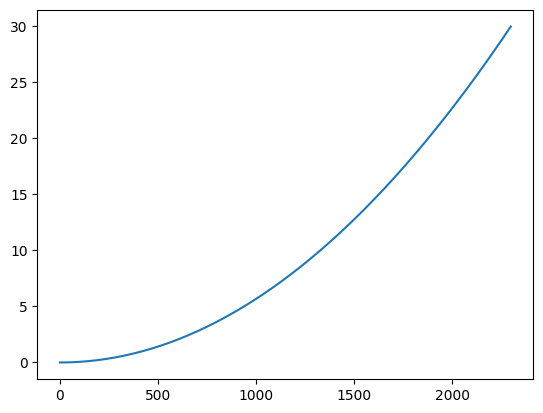

In [94]:
plt.plot(x0, z0)
plt.show()

In [95]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [96]:
init=1
for j in range(1,12):
    if j==1:
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:
        q0[(j-1)*node_N:j*node_N]=z0

In [97]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [98]:
V_rho=np.zeros(Irho_.shape)
np.fill_diagonal(V_rho, vessel_inertia)

In [99]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)
# M_t=inert(0*9.81,mp*9.81, x0)
# Irho=inert(0,Irho_ , x0)

In [100]:
def static_func(Q): # It is not working properly for non zero roll, pitch and yaw; serves our needs though
    t=0

    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)


    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]

    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]

    tau_force=np.array([-Fx_0,0,0,0,0,0])

    Z0= - np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T


    Z =  Z1 + Z2 + Z0


############################################################

    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################



    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1))

    C3=d_me(φ,θ,ψ,Ret,  ωe(φ,θ,ψ,None,None,None))

    B_ =C3
    B=(B_ + C0.squeeze())

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=scipy.linalg.lstsq(A[i],B[i], check_finite=True)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)

    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)


    return ans

In [101]:
q0

array([0.00000000e+00, 4.69050129e+01, 9.38100257e+01, 1.40715039e+02,
       1.87620051e+02, 2.34525064e+02, 2.81430077e+02, 3.28335090e+02,
       3.75240103e+02, 4.22145116e+02, 4.69050129e+02, 5.15955142e+02,
       5.62860154e+02, 6.09765167e+02, 6.56670180e+02, 7.03575193e+02,
       7.50480206e+02, 7.97385219e+02, 8.44290232e+02, 8.91195244e+02,
       9.38100257e+02, 9.85005270e+02, 1.03191028e+03, 1.07881530e+03,
       1.12572031e+03, 1.17262532e+03, 1.21953033e+03, 1.26643535e+03,
       1.31334036e+03, 1.36024537e+03, 1.40715039e+03, 1.45405540e+03,
       1.50096041e+03, 1.54786542e+03, 1.59477044e+03, 1.64167545e+03,
       1.68858046e+03, 1.73548548e+03, 1.78239049e+03, 1.82929550e+03,
       1.87620051e+03, 1.92310553e+03, 1.97001054e+03, 2.01691555e+03,
       2.06382057e+03, 2.11072558e+03, 2.15763059e+03, 2.20453560e+03,
       2.25144062e+03, 2.29834563e+03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [102]:
root_ = root(static_func, q0)

In [103]:
root_

 message: The iteration is not making good progress, as measured by the 
            improvement from the last ten iterations.
 success: False
  status: 5
     fun: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
       x: [ 0.000e+00  4.691e+01 ...  0.000e+00  0.000e+00]
  method: hybr
    nfev: 1211
    fjac: [[ 0.000e+00  0.000e+00 ... -3.497e-18 -3.393e-18]
           [ 0.000e+00  0.000e+00 ... -5.497e-09 -8.692e-15]
           ...
           [ 0.000e+00  0.000e+00 ...  1.097e-12 -2.231e-13]
           [ 0.000e+00  0.000e+00 ... -2.807e-10 -1.485e-10]]
       r: [-2.220e+03 -2.220e+03 ...  0.000e+00  0.000e+00]
     qtf: [ 3.879e-02  3.975e+02 ...  0.000e+00  0.000e+00]

In [104]:
x0_,z0_=root_.x[:node_N],root_.x[4*node_N:5*node_N]

In [105]:
q0=root_.x

In [106]:
q0

array([0.00000000e+00, 4.69050129e+01, 9.38100257e+01, 1.40715039e+02,
       1.87620051e+02, 2.34525064e+02, 2.81430077e+02, 3.28335090e+02,
       3.75240103e+02, 4.22145116e+02, 4.69050129e+02, 5.15955142e+02,
       5.62860154e+02, 6.09765167e+02, 6.56670180e+02, 7.03575193e+02,
       7.50480206e+02, 7.97385219e+02, 8.44290232e+02, 8.91195244e+02,
       9.38100257e+02, 9.85005270e+02, 1.03191028e+03, 1.07881530e+03,
       1.12572031e+03, 1.17262532e+03, 1.21953033e+03, 1.26643535e+03,
       1.31334036e+03, 1.36024537e+03, 1.40715039e+03, 1.45405540e+03,
       1.50096041e+03, 1.54786542e+03, 1.59477044e+03, 1.64167545e+03,
       1.68858046e+03, 1.73548548e+03, 1.78239049e+03, 1.82929550e+03,
       1.87620051e+03, 1.92310553e+03, 1.97001054e+03, 2.01691555e+03,
       2.06382057e+03, 2.11072558e+03, 2.15763059e+03, 2.20453560e+03,
       2.25144062e+03, 2.29834563e+03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

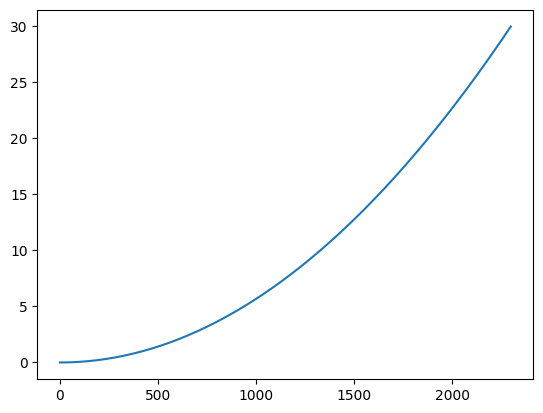

In [107]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [108]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [109]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L

    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3],
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])


    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = math.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])


    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)

In [110]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]

    return K

In [111]:
def FEA_u(coord, elcon, bc_node, bc_val, vessel_movement, coefs,
          E=210e9, G=84e9, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):


    coord=np.array(coord)
    elcon=np.array(elcon)

    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))

    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
#     print(K)  

      


    tmp = root(lambda x: x - K@np.array(vessel_movement), np.zeros(len(vessel_movement)))
#     print(tmp.success)
    glob_force=tmp.x
#     print(np.isclose(np.linalg.pinv(K)@glob_force - np.array(vessel_movement), np.zeros(len(vessel_movement)) ))
    glob_force[-6:]=np.multiply(glob_force[-6:], coefs)
    F=np.zeros(len(coord)*6)

    for i in range(len(vessel_movement)):
        if vessel_movement[i]:
            F[i]=glob_force[i]

#     f=ku 
    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m

    bc=np.array([bc_node,
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=scipy.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, check_finite=True)[0]
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    

#     Q=np.dot(K,d).T-F
    return d, np.dot(K,d).T

In [112]:
# 10 The Space Frame Element - verification
d,f=FEA_u(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [1, 2],
                      [2, 3]]),
        bc_node=list(range(6)),
        bc_val=[0]*6,
        vessel_movement=[
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                        -0.0705e-4,-0.0007e-4,0.1418e-4,0.0145e-4,0.0175e-4,0.0114e-4],
        coefs=[1,1,1,1,1,1])

In [113]:
-0.0705e-4, -0.0007e-4, 0.1418e-4

(-7.05e-06, -7e-08, 1.418e-05)

In [114]:
# f=k*d
# k^-1*f=d

In [115]:
d

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -3.44304000e-08,  6.05718317e-04,
       -9.47786515e-04, -1.23428564e-02,  9.41881267e-04,  6.08703365e-04,
       -5.46459404e-03, -4.17238913e-02,  4.52110880e-03, -1.32885436e-02,
        2.25929495e-03,  1.40011664e-03,  6.90670736e-03, -1.85833039e-03,
        5.76894634e-02, -1.32870936e-02,  2.26104495e-03,  1.40125664e-03])

In [116]:
f

array([ 4.82025600e+01,  5.73695230e+03, -4.34033027e+03,  1.72799990e+04,
       -8.26734720e+01,  8.35813440e+01,  3.41281065e-09,  3.18314394e-09,
       -1.02840068e-09,  1.60779105e-10,  5.26560594e-11, -3.54849913e-10,
        3.92537913e-09, -1.11758709e-08,  9.31322575e-09, -2.03726813e-10,
        1.52795110e-10, -3.63797881e-11, -4.82025600e+01, -5.73695230e+03,
        4.34033027e+03,  8.13220800e+01,  8.26734720e+01,  1.09228896e+02])

In [117]:
def PipeForce(X,Y,Z,vessel_movement,coefs, E=210e9, G=84e9,  
#               A=Ar, Iy=39.4925/7860, Iz=39.4925/7860, J=1.0062*1e-2,
              A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5
             ):
    coord=np.stack((X,Y,Z)).T
    elcon=[]
    for i in range(1,len(X)):
        elcon.append([i-1,i])

    bc_node=list(range(6))
    bc_val=[0]*6

    vessel_move=np.zeros(len(X)*6)
    vessel_move[-6:]=vessel_movement

    d,f=FEA_u(coord,elcon,bc_node,bc_val,vessel_move, coefs, E,G,A,Iy,Iz,J)

    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])

    mom =[]
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])

    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3])
    return np.array(fors), np.array(mom), np.array(angle)

In [118]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,
[0.01,
 0.02,
 0.03,
 0.01,
 -0.05,
 0.03],
 [1,1,1,1,1,1]
)

In [119]:
fors

array([[-9.63925637e+05,  3.30565432e+03, -2.21100462e+04],
       [ 1.32143497e-04,  7.31076580e-04, -1.02970898e-02],
       [ 1.96337700e-04,  2.42602685e-03, -1.71019137e-02],
       [ 4.07874584e-04,  9.57415987e-04,  1.07326228e-02],
       [ 4.36782837e-04,  2.14397162e-03,  1.56056781e-02],
       [ 5.98907471e-04, -1.80080533e-04, -2.15480030e-02],
       [ 2.40325928e-04, -9.78752971e-04,  2.99274921e-04],
       [ 4.04357910e-04,  3.35405686e-03,  1.94570869e-02],
       [ 4.23431396e-04, -6.46632910e-03, -2.90569812e-02],
       [-6.40869141e-04,  4.81727719e-03,  2.69147158e-02],
       [ 7.01904297e-04, -9.43705440e-04, -2.11694241e-02],
       [-2.97546387e-04, -1.82344605e-03,  1.32366419e-02],
       [-1.60217285e-04,  5.52168489e-03, -8.20803642e-03],
       [ 1.52587891e-04, -8.77183676e-03,  4.97722626e-03],
       [ 6.10351562e-05,  7.18557835e-03, -1.88207626e-03],
       [-5.18798828e-04, -3.75585972e-03,  7.01665878e-04],
       [-9.00268555e-04,  2.13137269e-03

### Vessle Simulation

In [120]:
sampleTime = 0.001              # sample time [seconds]
N = 100000                      # number of samples

In [121]:
N*sampleTime

100.0

In [122]:
vehicle=semisub('DPcontrol',2,-1,40.0,0,0)

In [123]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [124]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

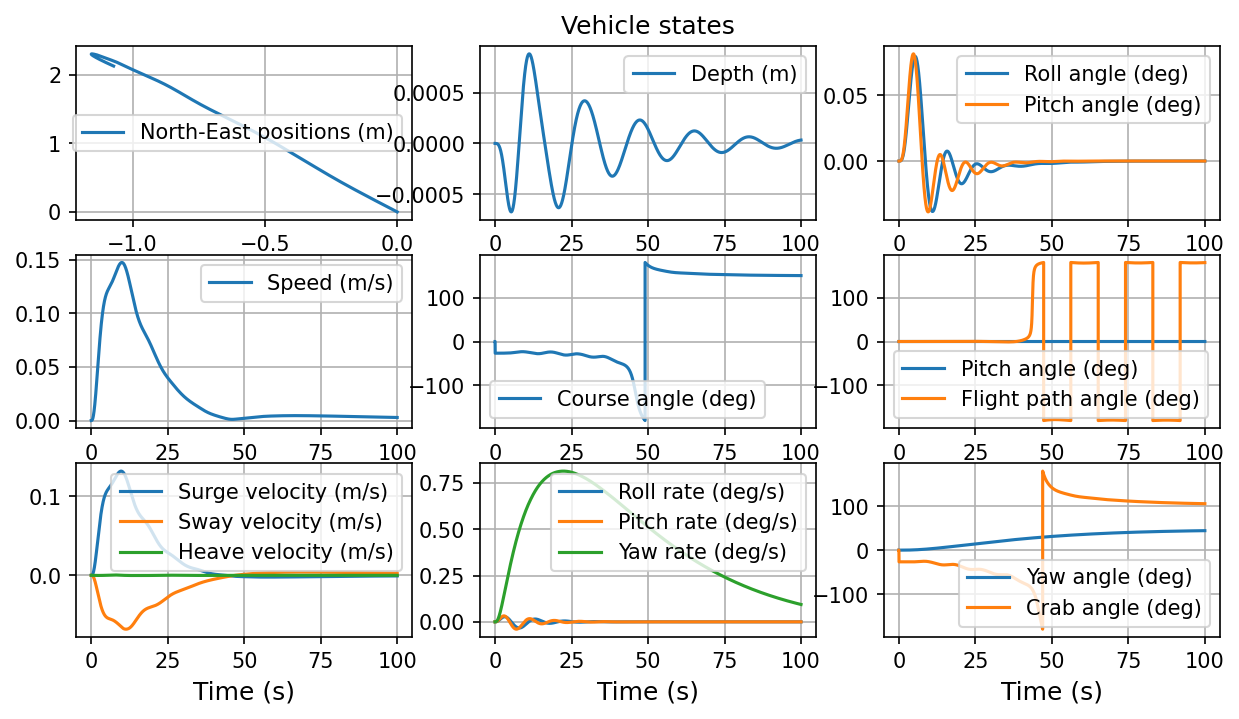

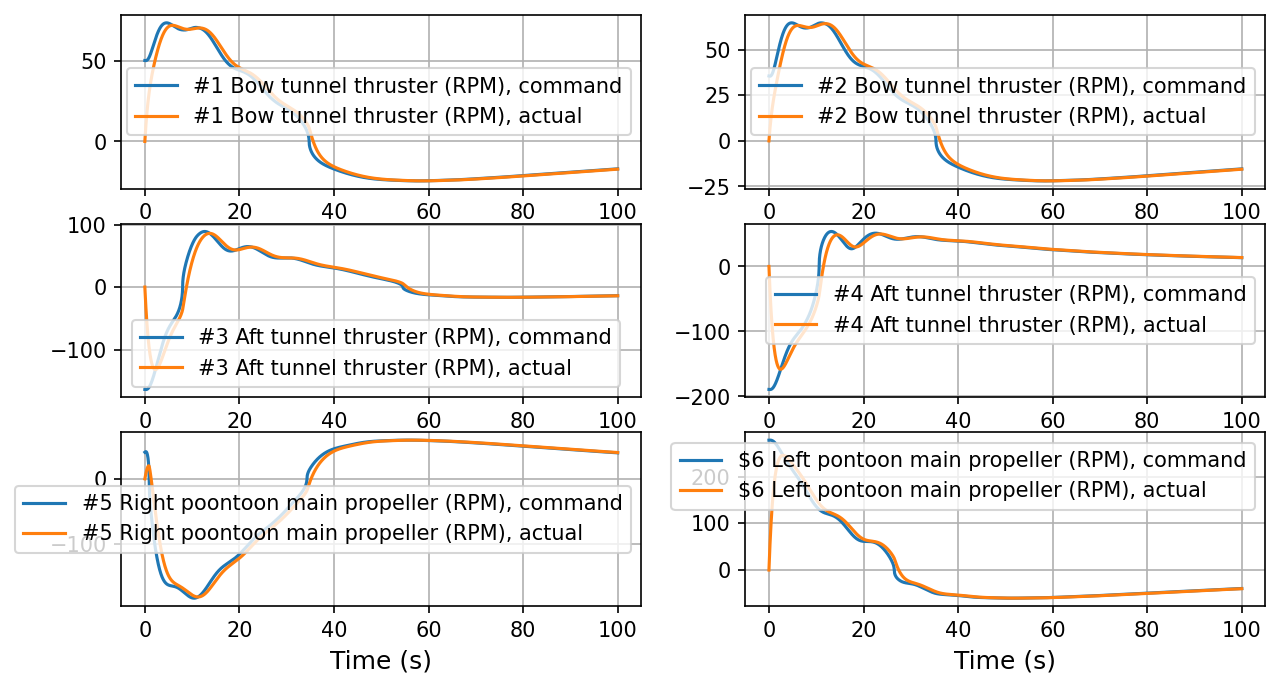

In [125]:
plotVehicleStates(simTime, simData, 1)
plotControls(simTime, simData, vehicle, 2)

In [126]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'

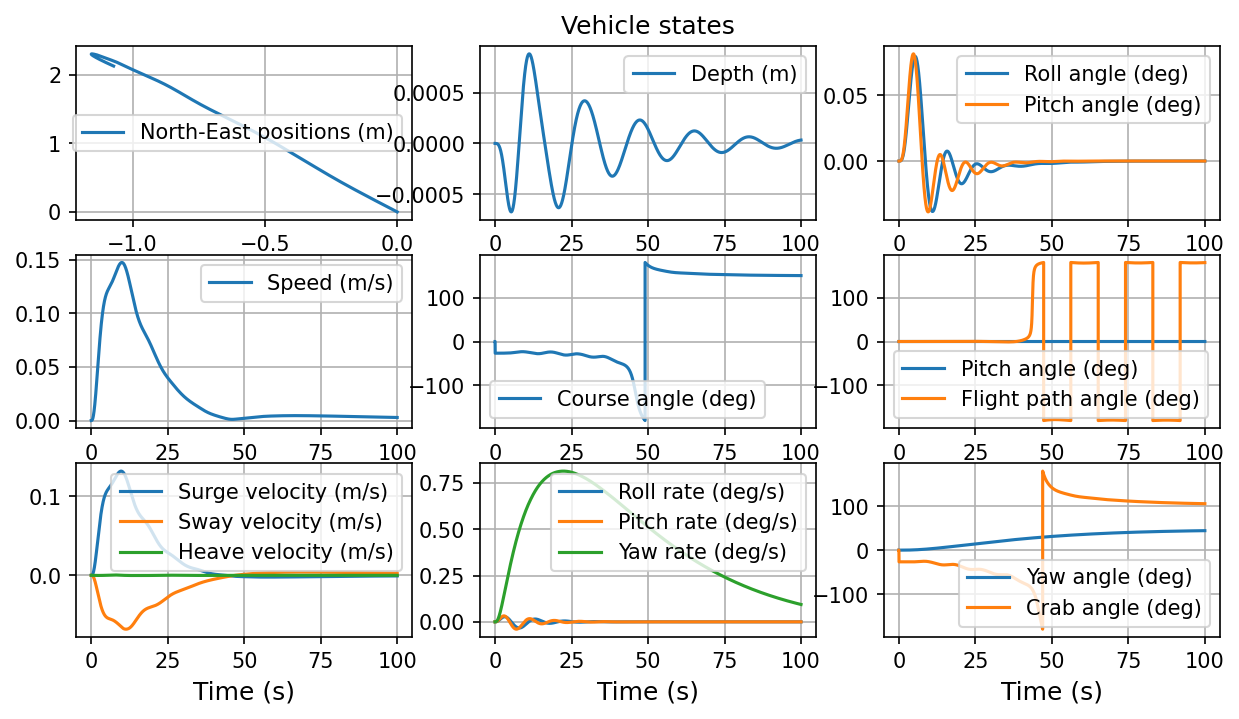

In [127]:
plotVehicleStates(simTime, simData, 3)

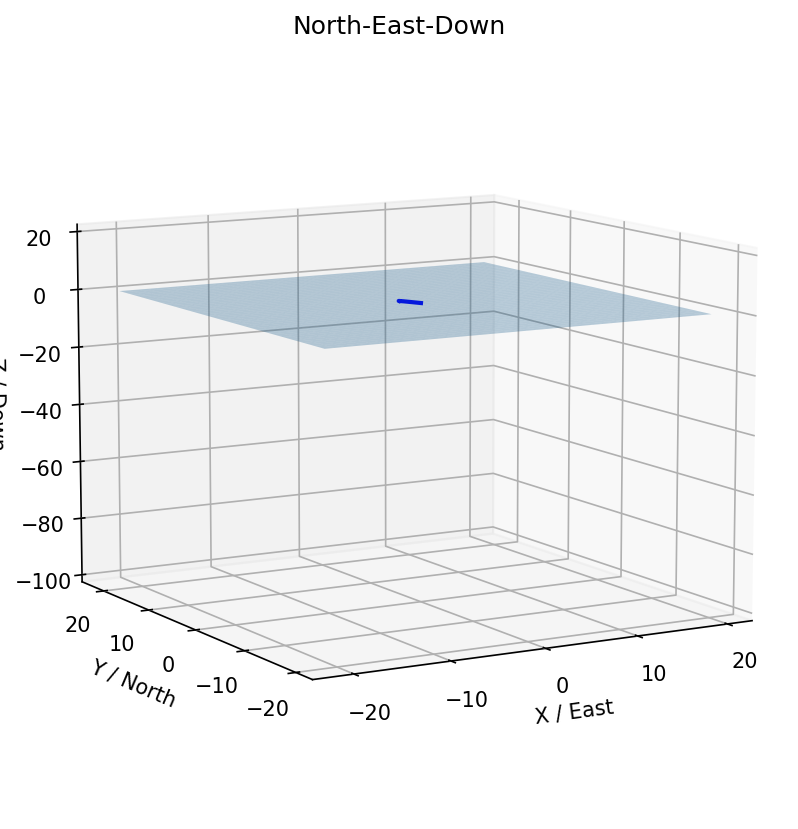

In [128]:
plot3D(simData, numDataPoints, FPS, filename, 3)

In [129]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [130]:
idx=1/0.01

In [131]:
idx

100.0

In [132]:
ssa(simData[:, 3][int(idx)])

4.347863402642815e-09

In [133]:
ssa(simData[:, 4][int(idx)])

5.966248384225992e-09

In [134]:
ssa(simData[:, 5][int(idx)])

1.3685324873335958e-08

In [135]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [136]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)
# M_t=inert(0,mp*9.81, x0)
# Irho=inert(0,Irho_ , x0)

### Dynamics

In [137]:
class MyTime:
    def __init__(self):
        self.my_t = 0
        self.v_m = np.array([0,0,0,0,0,0]).astype(np.float64)
        self.progression = [i for i in range(250)]
        self.wall_clock = datetime.now()

In [138]:
def grayscott1d(t, Q, coefs, T):
#     print(t,T.my_t,t-T.my_t)
#     print(t)
#     if (t-T.my_t)!=0 and abs(t-T.my_t)<1e-10:
#         return 'error'

    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]

    idx = find_nearest(np.array(ans_t),  t)

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])




#     u_ve = simData[:, 6][idx]
#     v_ve = simData[:, 7][idx]
#     w_ve = simData[:, 8][idx]
#     p_ve = simData[:, 9][idx]
#     q_ve = simData[:, 10][idx]
#     r_ve = simData[:, 11][idx]


#     η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])

#     dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])


#     n_ = myDPcontrol(vehicle,η,dη,sampleTime)
#     print(n_[2])


    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]


#     φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]

#     φ=ssa(φ)
#     θ=ssa(θ)
#     ψ=ssa(ψ)
#     Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]


    vessel_movement = np.zeros(6).astype(np.float64)
    vessel_movement[0] = x_ve - T.v_m[0]
    vessel_movement[1] = y_ve - T.v_m[1]
    vessel_movement[2] = -z_ve  - T.v_m[2]
    vessel_movement[3] = phi_ve - T.v_m[3]
    vessel_movement[4] = theta_ve  - T.v_m[4]
    vessel_movement[5] = psi_v- T.v_m[5]

    T.v_m[0] = x_ve
    T.v_m[1] = y_ve
    T.v_m[2] = -z_ve
    T.v_m[3] = phi_ve
    T.v_m[4] = theta_ve
    T.v_m[5] = psi_v


    fors, mom, angle = PipeForce(x, y, z, vessel_movement, coefs)

    φ,θ,ψ=angle.T
    Ret = Re_t(φ,θ,ψ)

    Z0= - np.einsum('ijk,ik->ij', Re_b(Ret), fors).squeeze()

    Z1=d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    Z2=ne_(dx,dy,dz,DT,Ret).T


    Z= (
        Z1
        + Z2
        +Z0
       )

############################################################
    RRRR=Re_b(Ret)


    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_t,Re_b(Ret)),Z).T

    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################


    C1=np.einsum('ijk,ik->ij', Irho_e(Ret,Irho).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64),
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))

    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)

    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret,Irho).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))

    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))

    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)

    C0=-np.einsum('ijk,ik->ij', np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)), mom ).squeeze()
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)

############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################
    T.my_t=t

    if t>T.progression[0]:
        T.progression.pop(0)
#         print(T.progression)
        print('Physical time: ', t, ' Iteration wall clock time: ', datetime.now() - T.wall_clock )
        T.wall_clock = datetime.now()

#     T.v_m=np.copy(vessel_movement)

    return np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

In [139]:
tspan = (0., 25)
T_ = MyTime()

In [140]:
coefs = [1, 1, 1, 1, 1, 1]

In [ ]:
startTime1 = datetime.now()
us=solve_ivp(grayscott1d,
             tspan,
             q0,
             
#             method='LSODA',
#              t_eval=[i*sampleTime for i in range(int(tspan[-1]/(sampleTime)))],
#              atol=1e-2,
             args=(coefs,T_,))
print(datetime.now() - startTime1)

Physical time:  0.3462419251416382  Iteration wall clock time:  0:00:01.039709


### Results

In [ ]:
fin=us

In [ ]:
fin

In [ ]:
t=fin.t

In [ ]:
fin=fin.y.T

In [ ]:
fig=plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection = '3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b')
# ax.plot(x_fine, y_fine, z_fine, color='b')
# ax.view_init(-45,-45)
# ax.view_init(-30,-30)
ax.view_init(0,-90)
plt.show()

In [ ]:
X,Y,Z

In [ ]:
X0,Y0,Z0

In [ ]:
us=fin.T

In [ ]:
us.shape

In [ ]:
12*50

In [ ]:
us.T[:,4*node_N+49]

In [ ]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,3*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('dy49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,11*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('dψ49')
plt.show()